# Futurama Super-resolution
This project will aim to create higher resolution versions of early Futurama episodes. Luckily, the later seasons are in 1080p, and will therefore be used to generate ground truth and from them downscaled inputs can be generated.

First, we need to generate the training data. This will be done by converting futurama episodes into a set of images. Initially, let's start by attempting to do superresolution on 64x64 -> 128x128 squares of the image. Since the old episodes are in the format 640x480, I think a resolution of 1280x960 would be good enough. So the order of increase in resolution is 4 times as many pixels.

In [1]:
import cv2
from tqdm.notebook import tqdm
low_resolution = (64, 64)
high_resolution = (128, 128)

## Generating training data
Now we need to create the data. This is done by grabbing random crops of a Futurama episode.
![Futurma shot crop](resources/futurama_shot.png)

The cropped image is then downscaled to a lower resolution, which will be the input and then the high resolution is the target for the model.

High resolution                                          | Low resolution (downscaled)
:-------------------------------------------------------:|:----------------------------------------------------:
![Shot crop high resolution](resources/highres_crop.png) | ![Shot crop low resolution](resources/lowres_crop.png)

In [ ]:
import random, os

if not os.path.exists('highres'):
    os.makedirs('highres')
    
if not os.path.exists('lowres'):
    os.makedirs('lowres')

cap = cv2.VideoCapture("video/sample0.mkv")

s, frame0 = cap.read()

# Skip the first 100 frames
#cap.set(cv2.CAP_PROP_POS_FRAMES, 1000)

cw, ch = high_resolution

max_start_crop_x, max_start_crop_y = (frame0.shape[1] - cw, frame0.shape[0] - ch)

frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)

i=0
for _ in tqdm(range(int(frames - 1))):
    if not cap.isOpened():
        break
    
    ret, frame = cap.read()
    
    cx = random.randint(0, max_start_crop_x)
    cy = random.randint(0, max_start_crop_y)
    
    crop = frame[cy:(cy+ch), cx:(cx+cw)]
    lowres_crop = cv2.resize(crop, low_resolution, interpolation=cv2.INTER_AREA)
    #lowres_upscaled = cv2.resize(lowres_crop, high_resolution, interpolation=cv2.INTER_CUBIC)

    cv2.imwrite('highres/sample'+str(i)+'.png', crop)
    cv2.imwrite('lowres/sample'+str(i)+'.png', lowres_crop)
    i += 1
 
cap.release()

### Loading data to tensors
Next up, we need to load this data into the tensor format for use in pytorch. We define our own dataset `ImageInputTargetDataset`, which will be able to generate input-target datapoints from images in two different folders.

In [2]:
import os
from PIL import Image
from torch.utils.data import Dataset
import numpy as np

def img_to_tensor(img_path):
        return torch.from_numpy(np.asarray(cv2.imread(img_path))).double().permute(2,0,1)[[2,1,0], :, :]
    
class ImageInputTargetDataset(Dataset):
    def __init__(self, input_path: str, target_path: str, extension="png", prefix="", transform=None):
        self.input_path = input_path
        self.target_path = target_path
        self.transform = transform
        self.image_path_template = "{}/" + "{}".format(prefix) + "{}." + "{}".format(extension)
    
    def __len__(self):
        return len(os.listdir(self.input_path))
    
    
    
    def __getitem__(self, idx):
        
        input_img = img_to_tensor(self.image_path_template.format(self.input_path, idx)) / 256.0
        target_img = img_to_tensor(self.image_path_template.format(self.target_path, idx)) / 256.0
        
        if self.transform:
            input_img = self.transform(input_img)
            target_img = self.transform(target_img)
        
        return [input_img, target_img]
        

With this dataset format defined, we can create a `DataLoader` for it. This class can load the datapoints in batches.

In [3]:
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Normalize

batch_size = 128

dataset = ImageInputTargetDataset("lowres", "highres", prefix="sample",
                                  transform=Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)))

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [4]:
def denorm(img_tensors):
    return img_tensors * 0.5 + 0.5

def display_imgs(imgs):
    _, axs = plt.subplots(1,len(imgs))
    for i in range(len(imgs)):
        axs[i].imshow(denorm(imgs[i]).permute(1,2,0))

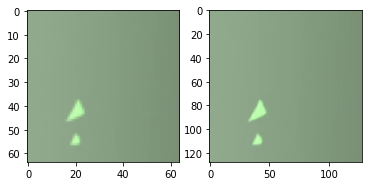

In [5]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

for lr, hr in dataloader:
    display_imgs([lr[0], hr[0]])
    break

## Creating the model 
The model that we will use is a simple transpose convolutional neural network.

In [6]:
import torch.nn as nn

class FuturamaModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        # input size 3x64x64
        self.conv = nn.Sequential(
            nn.Conv2d(3, 90, kernel_size=6, stride=2, padding=2),
            nn.BatchNorm2d(90),
            nn.LeakyReLU(0.2, inplace=True), # 90x32x32
            
            nn.Conv2d(90, 300, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(300),
            nn.LeakyReLU(0.2, inplace=True), # 300x16x16
            
            nn.Conv2d(300, 768, kernel_size=2, stride=2, padding=0),
            nn.BatchNorm2d(768),
            nn.LeakyReLU(0.2, inplace=True), # 768x8x8
        )
        
        self.sub_pixel = nn.PixelShuffle(16) #3x128x128
        
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        
        self.final = nn.Tanh()
        
    def forward(self, xb):
        upsampled = self.upsample(xb)
        
        out = self.conv(xb)
        out = self.sub_pixel(out)
        out = out + upsampled
        out = self.final(out)
        
        return out

model = FuturamaModel().double()

torch.Size([3, 128, 128])


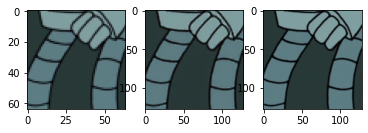

In [22]:
for lr, hr in dataloader:
    print(model(lr).detach()[0].shape)
    display_imgs([lr[0], model(lr).detach()[0], hr[0]])
    break

In [8]:
import torch

train_history = []
def train(num_epochs, lr, nbatches=-1):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fun = nn.MSELoss(reduction='sum')
    
    #model.train()
    
    for epoch in range(num_epochs): 
        epoch_loss = []
        i = 0
        for lowres, highres in tqdm(dataloader):
            if nbatches != -1 and i > nbatches:
                break
            
            # Reset gradients
            optimizer.zero_grad()
            
            # Evaluate on model
            output = model(lowres)
            
            # Calculate loss. Target is the input
            loss = loss_fun(output, highres)
            
            # Compute new gradients
            loss.backward()
            
            # Perform step
            optimizer.step()
            
            epoch_loss.append(loss.detach().item())
            i += 1
        
        avg_loss = sum(epoch_loss) / len(epoch_loss)
        train_history.append(avg_loss)
        print('Epoch [{}/{}], loss: {:.4f}'.format(epoch+1, num_epochs, avg_loss))
    if num_epochs > 1:
        plt.plot(train_history)
        plt.show()

In [9]:
model.load_state_dict(torch.load('model.ckpt'))

<All keys matched successfully>

  0%|          | 0/244 [00:00<?, ?it/s]

Epoch [1/5], loss: 7167.2087


  0%|          | 0/244 [00:00<?, ?it/s]

Epoch [2/5], loss: 7097.9820


  0%|          | 0/244 [00:00<?, ?it/s]

Epoch [3/5], loss: 7126.7990


  0%|          | 0/244 [00:00<?, ?it/s]

Epoch [4/5], loss: 7127.5560


  0%|          | 0/244 [00:00<?, ?it/s]

Epoch [5/5], loss: 6971.3873


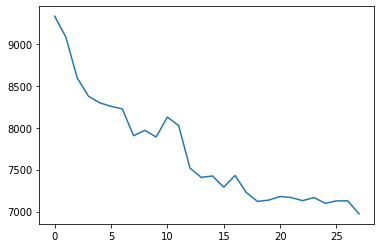

In [23]:
train(5, 7e-4)

torch.save(model.state_dict(), 'model.ckpt')

## Things that did not work

A U-net of convolutional and deconvolutional layers did not work. At best this achieved the identity function, which is of course useless. Using res-net seems to help, but again, this makes it much easier to achieve the identity function, which means it might not be a sign that it works after all.